In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Cài đặt các thư viện với phiên bản tương thích
!pip install tensorflow==2.14.0
!pip install numpy
!pip install opencv-python
!pip install matplotlib
!pip install scikit-learn
!pip install Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 123.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 123.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 20.5 MB/s eta 0:00:00


In [1]:
!pip install numpy==1.26.4

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import glob
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Reset TensorFlow session
tf.keras.backend.clear_session()

# Thiết lập GPU và memory growth
print("TensorFlow version:", tf.__version__)
print("Checking GPU availability...")

try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"GPU available: {len(gpus)} GPU(s)")
        except RuntimeError as e:
            print(f"GPU setup error: {e}")
    else:
        print("No GPU found, using CPU")
except Exception as e:
    print(f"GPU check error: {e}")

class FallDetectionDataset:
    def __init__(self, image_dir, label_dir, img_size=(224, 224)):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.img_size = img_size
        self.num_classes = 3  # 0: fallen, 1: not fallen, 2: other

        # Kiểm tra thư mục tồn tại
        if not os.path.exists(image_dir):
            raise ValueError(f"Image directory không tồn tại: {image_dir}")
        if not os.path.exists(label_dir):
            raise ValueError(f"Label directory không tồn tại: {label_dir}")

    def parse_yolo_annotation(self, annotation_path):
        """Parse YOLO format annotation"""
        boxes = []
        classes = []

        try:
            if os.path.exists(annotation_path):
                with open(annotation_path, 'r') as f:
                    lines = f.readlines()

                for line in lines:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        x_center = float(parts[1])
                        y_center = float(parts[2])
                        width = float(parts[3])
                        height = float(parts[4])

                        # Validate coordinates
                        if 0 <= x_center <= 1 and 0 <= y_center <= 1 and 0 <= width <= 1 and 0 <= height <= 1:
                            boxes.append([x_center, y_center, width, height])
                            classes.append(class_id)
        except Exception as e:
            print(f"Error parsing {annotation_path}: {e}")

        return np.array(boxes), np.array(classes)

    def load_image(self, image_path):
        """Load and preprocess image"""
        try:
            # Try với OpenCV
            image = cv2.imread(image_path)
            if image is None:
                # Try với PIL
                image = Image.open(image_path)
                image = np.array(image)
                if len(image.shape) == 3 and image.shape[2] == 3:
                    # RGB to BGR cho consistency
                    pass
            else:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if image is None:
                return None

            # Resize và normalize
            image = cv2.resize(image, self.img_size)
            image = image.astype(np.float32) / 255.0

            # Ensure 3 channels
            if len(image.shape) == 2:
                image = np.stack([image] * 3, axis=-1)
            elif image.shape[2] == 4:  # RGBA
                image = image[:, :, :3]

            return image

        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None

    def create_dataset(self):
        """Create dataset from images and annotations"""
        images = []
        labels = []

        # Get all image files
        image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.JPG', '*.JPEG', '*.PNG']
        image_files = []

        for ext in image_extensions:
            image_files.extend(glob.glob(os.path.join(self.image_dir, ext)))

        print(f"Found {len(image_files)} images in {self.image_dir}")

        valid_samples = 0
        for i, image_path in enumerate(image_files):
            if i % 100 == 0:
                print(f"Processing image {i+1}/{len(image_files)}")

            # Load image
            image = self.load_image(image_path)
            if image is None:
                continue

            # Get corresponding annotation file
            base_name = os.path.splitext(os.path.basename(image_path))[0]
            annotation_path = os.path.join(self.label_dir, f"{base_name}.txt")

            # Parse annotation
            boxes, classes = self.parse_yolo_annotation(annotation_path)

            # For classification, use the first detected class
            if len(classes) > 0:
                label = int(classes[0])
                # Ensure label is valid
                if 0 <= label < self.num_classes:
                    images.append(image)
                    labels.append(label)
                    valid_samples += 1
            else:
                # Nếu không có annotation, skip
                continue

        print(f"Successfully loaded {valid_samples} valid samples")

        if len(images) == 0:
            raise ValueError("No valid images found! Check your data paths and formats.")

        return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)

def create_simple_model(input_shape=(224, 224, 3), num_classes=3):
    """Create a simple CNN model for fall detection"""

    model = keras.Sequential([
        # Input layer
        layers.Input(shape=input_shape),

        # First conv block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second conv block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third conv block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Fourth conv block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),

        # Dense layers
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

def create_transfer_learning_model(input_shape=(224, 224, 3), num_classes=3):
    """Create model using transfer learning"""

    try:
        # Load pre-trained MobileNetV2
        base_model = keras.applications.MobileNetV2(
            input_shape=input_shape,
            include_top=False,
            weights='imagenet'
        )

        # Freeze base model initially
        base_model.trainable = False

        model = keras.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.2),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(num_classes, activation='softmax')
        ])

        return model

    except Exception as e:
        print(f"Error creating transfer learning model: {e}")
        print("Falling back to simple CNN model...")
        return create_simple_model(input_shape, num_classes)

def plot_training_history(history):
    """Plot training history"""
    try:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Plot training & validation accuracy
        ax1.plot(history.history['accuracy'], label='Training Accuracy')
        if 'val_accuracy' in history.history:
            ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()

        # Plot training & validation loss
        ax2.plot(history.history['loss'], label='Training Loss')
        if 'val_loss' in history.history:
            ax2.plot(history.history['val_loss'], label='Validation Loss')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting history: {e}")


TensorFlow version: 2.14.0
Checking GPU availability...
No GPU found, using CPU


In [6]:
def main():
    try:
        # Đọc cái thư mục chứa data
        TRAIN_IMAGE_DIR = "/content/drive/MyDrive/FALL DETECTION/fall_dataset/images/train"
        TRAIN_LABEL_DIR = "/content/drive/MyDrive/FALL DETECTION/fall_dataset/labels/train"
        VAL_IMAGE_DIR = "/content/drive/MyDrive/FALL DETECTION/fall_dataset/images/val"
        VAL_LABEL_DIR = "/content/drive/MyDrive/FALL DETECTION/fall_dataset/labels/val"

        # Nếu không có val riêng, có thể dùng train và split sau
        USE_TRAIN_VAL_SPLIT = False

        # Check if validation directories exist
        if not (os.path.exists(VAL_IMAGE_DIR) and os.path.exists(VAL_LABEL_DIR)):
            print("Validation directories not found. Will split training data.")
            USE_TRAIN_VAL_SPLIT = True

        # Hyperparameters
        IMG_SIZE = (224, 224)
        BATCH_SIZE = 16  # batch size thấp để tránh Out of Memory nhá!
        EPOCHS = 30
        LEARNING_RATE = 0.001

        print("=" * 50)
        print("FALL DETECTION MODEL TRAINING")
        print("=" * 50)

        print("Loading training data...")
        # Load training data
        train_dataset = FallDetectionDataset(TRAIN_IMAGE_DIR, TRAIN_LABEL_DIR, IMG_SIZE)
        train_images, train_labels = train_dataset.create_dataset()

        if USE_TRAIN_VAL_SPLIT:
            # Split training data into train/val
            train_images, val_images, train_labels, val_labels = train_test_split(
                train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels
            )
            print("Split training data into train/validation sets")
        else:
            print("Loading validation data...")
            val_dataset = FallDetectionDataset(VAL_IMAGE_DIR, VAL_LABEL_DIR, IMG_SIZE)
            val_images, val_labels = val_dataset.create_dataset()

        print(f"Train samples: {len(train_images)}")
        print(f"Validation samples: {len(val_images)}")
        print(f"Classes distribution in train: {np.bincount(train_labels)}")
        print(f"Classes distribution in val: {np.bincount(val_labels)}")

        # Validate labels
        unique_labels = np.unique(np.concatenate([train_labels, val_labels]))
        print(f"Unique labels found: {unique_labels}")

        num_classes = len(unique_labels)
        if num_classes != 3:
            print(f"Warning: Expected 3 classes, found {num_classes}")

        # Convert labels to categorical
        train_labels_cat = keras.utils.to_categorical(train_labels, num_classes=3)
        val_labels_cat = keras.utils.to_categorical(val_labels, num_classes=3)

        # Create model
        print("Creating model...")
        model = create_transfer_learning_model(input_shape=(*IMG_SIZE, 3), num_classes=3)

        # Compile model
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Model summary
        print("\nModel Summary:")
        model.summary()

        # Callbacks
        callbacks = [
            keras.callbacks.ModelCheckpoint(
                'best_fall_detection_model.h5',
                monitor='val_accuracy',
                save_best_only=True,
                mode='max',
                verbose=1
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-7,
                verbose=1
            ),
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=1
            )
        ]

        # Data augmentation (simple)
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            zoom_range=0.1,
            fill_mode='nearest'
        )

        # Fit the data generator
        datagen.fit(train_images)

        # Train model
        print("\nStarting training...")
        print(f"Training on {len(train_images)} samples, validating on {len(val_images)} samples")

        history = model.fit(
            datagen.flow(train_images, train_labels_cat, batch_size=BATCH_SIZE),
            steps_per_epoch=len(train_images) // BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=(val_images, val_labels_cat),
            callbacks=callbacks,
            verbose=1
        )

        # Plot training history
        plot_training_history(history)

        # Evaluate model
        print("\nEvaluating model...")
        val_loss, val_accuracy = model.evaluate(val_images, val_labels_cat, verbose=0)
        print(f"Final Validation Loss: {val_loss:.4f}")
        print(f"Final Validation Accuracy: {val_accuracy:.4f}")

        # Save final model
        model.save('best_fall_detection_model.h5')
        print("Model saved successfully!")

        return model, history

    except Exception as e:
        print(f"Error in main training function: {e}")
        import traceback
        traceback.print_exc()
        return None, None


Training...
FALL DETECTION MODEL TRAINING
Loading training data...
Found 374 images in /content/drive/MyDrive/FALL DETECTION/fall_dataset/images/train
Processing image 1/374
Processing image 101/374
Processing image 201/374
Processing image 301/374
Successfully loaded 374 valid samples
Loading validation data...
Found 111 images in /content/drive/MyDrive/FALL DETECTION/fall_dataset/images/val
Processing image 1/111
Processing image 101/111
Successfully loaded 111 valid samples
Train samples: 374
Validation samples: 111
Classes distribution in train: [207 167]
Classes distribution in val: [72 39]
Unique labels found: [0 1]
Creating model...

Model Summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                  

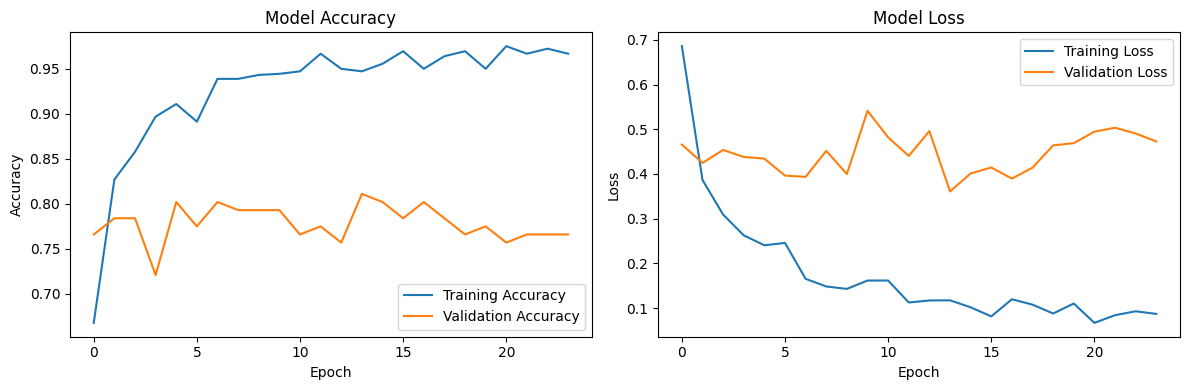


Evaluating model...
Final Validation Loss: 0.3609
Final Validation Accuracy: 0.8108
Model saved successfully!

TRAINING COMPLETED SUCCESSFULLY!


In [7]:
# Hàm để test model
def predict_image(model, image_path, img_size=(224, 224)):
    """Predict class for a single image"""
    class_names = ['Fallen', 'Not Fallen', 'Other']

    try:
        # Load and preprocess image
        image = cv2.imread(image_path)
        if image is None:
            image = Image.open(image_path)
            image = np.array(image)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image = cv2.resize(image, img_size)
        image = image.astype(np.float32) / 255.0
        image = np.expand_dims(image, axis=0)

        # Make prediction
        predictions = model.predict(image)
        predicted_class = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class]

        print(f"Predicted class: {class_names[predicted_class]}")
        print(f"Confidence: {confidence:.4f}")

        return predicted_class, confidence

    except Exception as e:
        print(f"Error predicting image {image_path}: {e}")
        return None, None

# Test function để check data loading
def test_data_loading():
    """Test function to check if data can be loaded correctly"""
    try:
        TRAIN_IMAGE_DIR = "/content/train/images"
        TRAIN_LABEL_DIR = "/content/train/labels"

        print("Testing data loading...")
        dataset = FallDetectionDataset(TRAIN_IMAGE_DIR, TRAIN_LABEL_DIR, (224, 224))

        # Try to load just a few samples
        image_files = glob.glob(os.path.join(TRAIN_IMAGE_DIR, "*.jpg"))[:5]

        for image_path in image_files:
            image = dataset.load_image(image_path)
            if image is not None:
                print(f"✓ Successfully loaded: {os.path.basename(image_path)} - Shape: {image.shape}")
            else:
                print(f"✗ Failed to load: {os.path.basename(image_path)}")

        print("Data loading test completed!")

    except Exception as e:
        print(f"Data loading test failed: {e}")

if __name__ == "__main__":
   # Chạy training
    print("Training...")
    model, history = main()

    if model is not None:
        print("\n" + "="*50)
        print("TRAINING COMPLETED SUCCESSFULLY!")
        print("="*50)

    else:
        print("Training failed. Please check the error messages above.")

In [8]:
import tensorflow as tf

# Tải mô hình đã lưu
model = tf.keras.models.load_model('best_fall_detection_model.keras')

# Chuyển đổi sang định dạng TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Lưu mô hình .tflite
with open('best_fall_detection_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Mô hình đã được chuyển đổi và lưu thành best_fall_detection_model.tflite")

Mô hình đã được chuyển đổi và lưu thành best_fall_detection_model.tflite


In [8]:
import tensorflow as tf

# Load model .h5
model = tf.keras.models.load_model("best_fall_detection_model.h5")

# Tạo converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# (Tuỳ chọn) Tối ưu hóa
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Chuyển thành .tflite
tflite_model = converter.convert()

# Lưu file .tflite
with open("best_fall_detection_model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Đã chuyển thành công sang .tflite")


✅ Đã chuyển thành công sang .tflite


In [9]:
import cv2
import numpy as np
import tensorflow as tf
from google.colab.patches import cv2_imshow
from IPython.display import display, clear_output
import time

# Load TFLite model
tflite_model_path = "best_fall_detection_model.tflite"
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Thông tin model
input_shape = input_details[0]['shape'][1:3]
print(f"Expected input size: {input_shape}")

# Hàm dự đoán từ ảnh frame
def predict_frame(frame):
    img = cv2.resize(frame, input_shape)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)

    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    return np.argmax(output), np.max(output)

# Nhãn class - chỉnh lại theo dataset bạn dùng
class_names = ['No Fall', 'Fall', 'Other']

# Mở webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Không mở được webcam")

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Không nhận được frame từ camera")
            break

        # Dự đoán
        pred_class, confidence = predict_frame(frame)
        label = f"{class_names[pred_class]} ({confidence:.2f})"

        # Vẽ kết quả lên khung hình
        cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Hiển thị
        clear_output(wait=True)
        cv2_imshow(frame)

        # Đợi 1 tí cho nhẹ máy, tránh treo
        time.sleep(0.1)

except KeyboardInterrupt:
    print("Dừng camera.")

cap.release()
cv2.destroyAllWindows()


Expected input size: [224 224]
Không mở được webcam
Không nhận được frame từ camera
